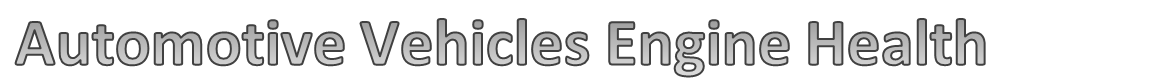

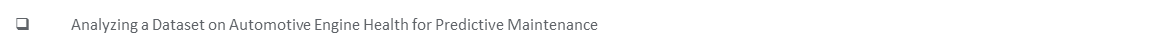

# Libraries import

In [80]:
## Data Manipulation
import pandas as pd
import numpy as np

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data Analysis
from collections import Counter
from scipy.stats import norm, stats, shapiro

## Machine Learning
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import PowerTransformer
import xgboost
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## MLflow
import mlflow
import tempfile
import os

## Oversampling and Undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

## Additional Metrics
from sklearn.metrics import recall_score

## JSON
import json

# Data import

In [2]:
df = pd.read_csv('C:/Users/td/predictive_maintenance/data/engine_data.csv')

# Data overview

In [3]:
df.head(2)

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0


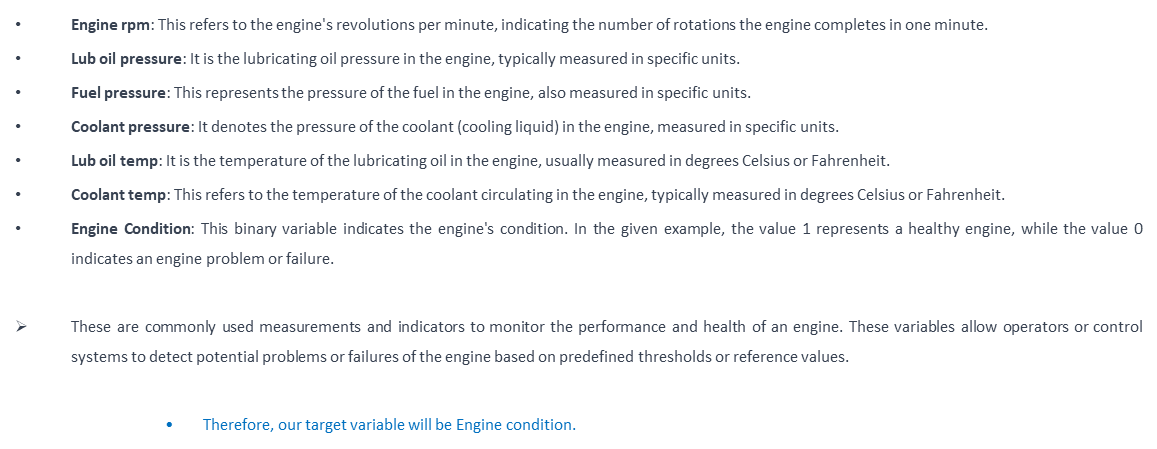

# Data cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
 6   Engine Condition  19535 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 1.0 MB


## Columns with single value

In [5]:
for column_ in df.columns:
    print(column_, ' :', len(np.unique(df[column_])),' differents values.')

Engine rpm  : 1379  differents values.
Lub oil pressure  : 19534  differents values.
Fuel pressure  : 19531  differents values.
Coolant pressure  : 19534  differents values.
lub oil temp  : 19530  differents values.
Coolant temp  : 19532  differents values.
Engine Condition  : 2  differents values.


## Columns and low variance

In [6]:
df.var()

Engine rpm          71615.750675
Lub oil pressure        1.043754
Fuel pressure           7.623235
Coolant pressure        1.074088
lub oil temp            9.678221
Coolant temp           38.523737
Engine Condition        0.232979
dtype: float64

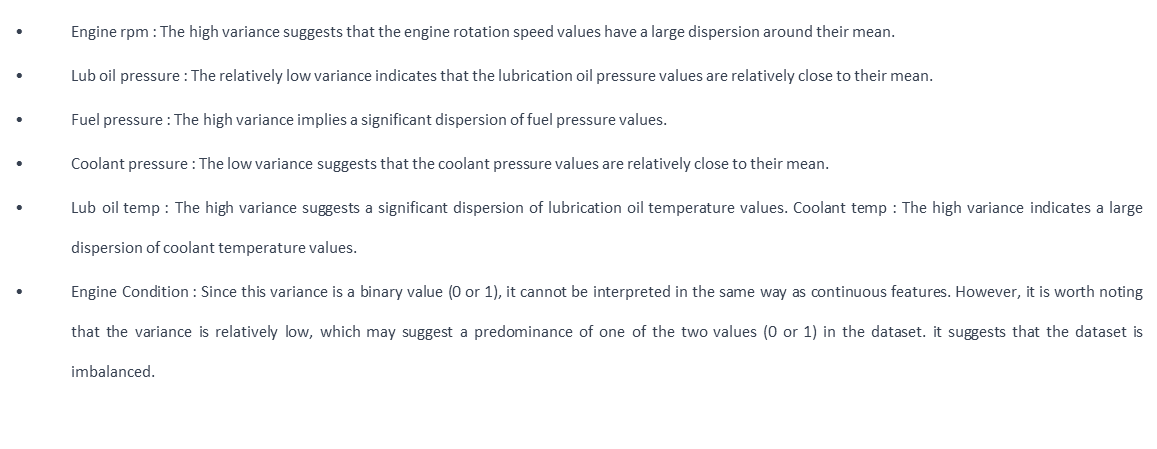

## Duplicate data

In [7]:
df[df.duplicated()==True]

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition


## Outliers

In [8]:
def outliers_(df, dev):
    columns_ = df.columns
    outliers_count = {}
    
    for i, variable in enumerate(columns_):
        data = df[variable]
        mean = np.mean(data)
        std = np.std(data)
        iqr = stats.iqr(data)
        
        lim_up = np.quantile(data, 0.75) + 1.5 * iqr
        lim_down = np.quantile(data, 0.25) - 1.5 * iqr

        outliers = data[(data > lim_up) | (data < lim_down)]
        outliers_count[variable] = {'count': len(outliers), 'percent': f"{len(outliers)/len(data)*100:.2f}%"}
        print(outliers_count[variable])
        sns.boxplot(data = data, x=df[variable])
        plt.show()
    return 



{'count': 464, 'percent': '2.38%'}


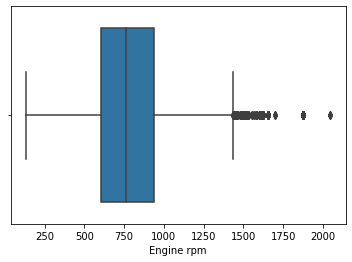

{'count': 66, 'percent': '0.34%'}


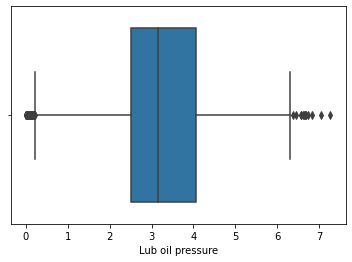

{'count': 1135, 'percent': '5.81%'}


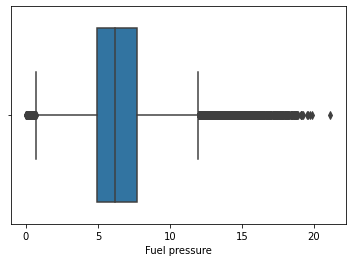

{'count': 785, 'percent': '4.02%'}


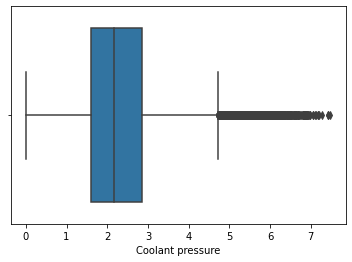

{'count': 2617, 'percent': '13.40%'}


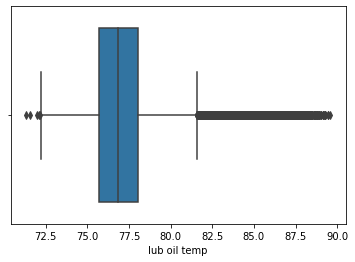

{'count': 2, 'percent': '0.01%'}


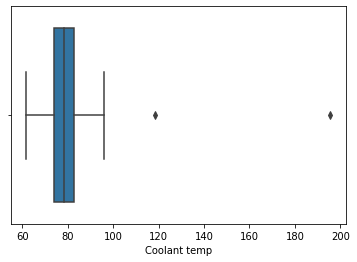

In [9]:
outliers_(df.iloc[:,:-1],2)

## Missing data

In [10]:
df.isna().sum()

Engine rpm          0
Lub oil pressure    0
Fuel pressure       0
Coolant pressure    0
lub oil temp        0
Coolant temp        0
Engine Condition    0
dtype: int64

# Data Exploration

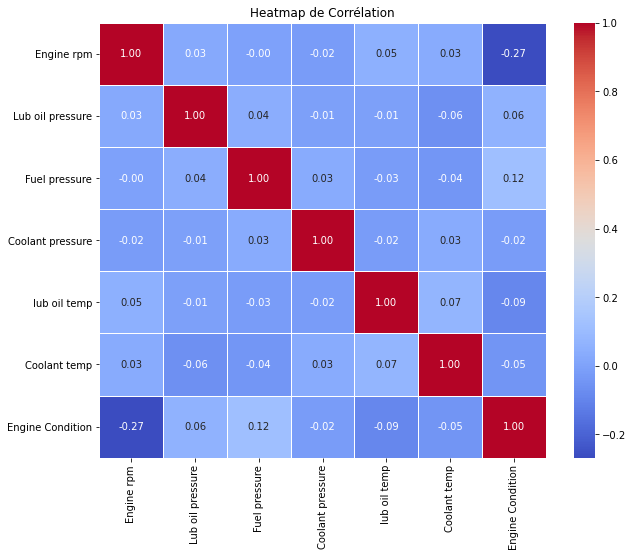

In [11]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap de Corrélation")
plt.show()

<Figure size 1080x1440 with 0 Axes>

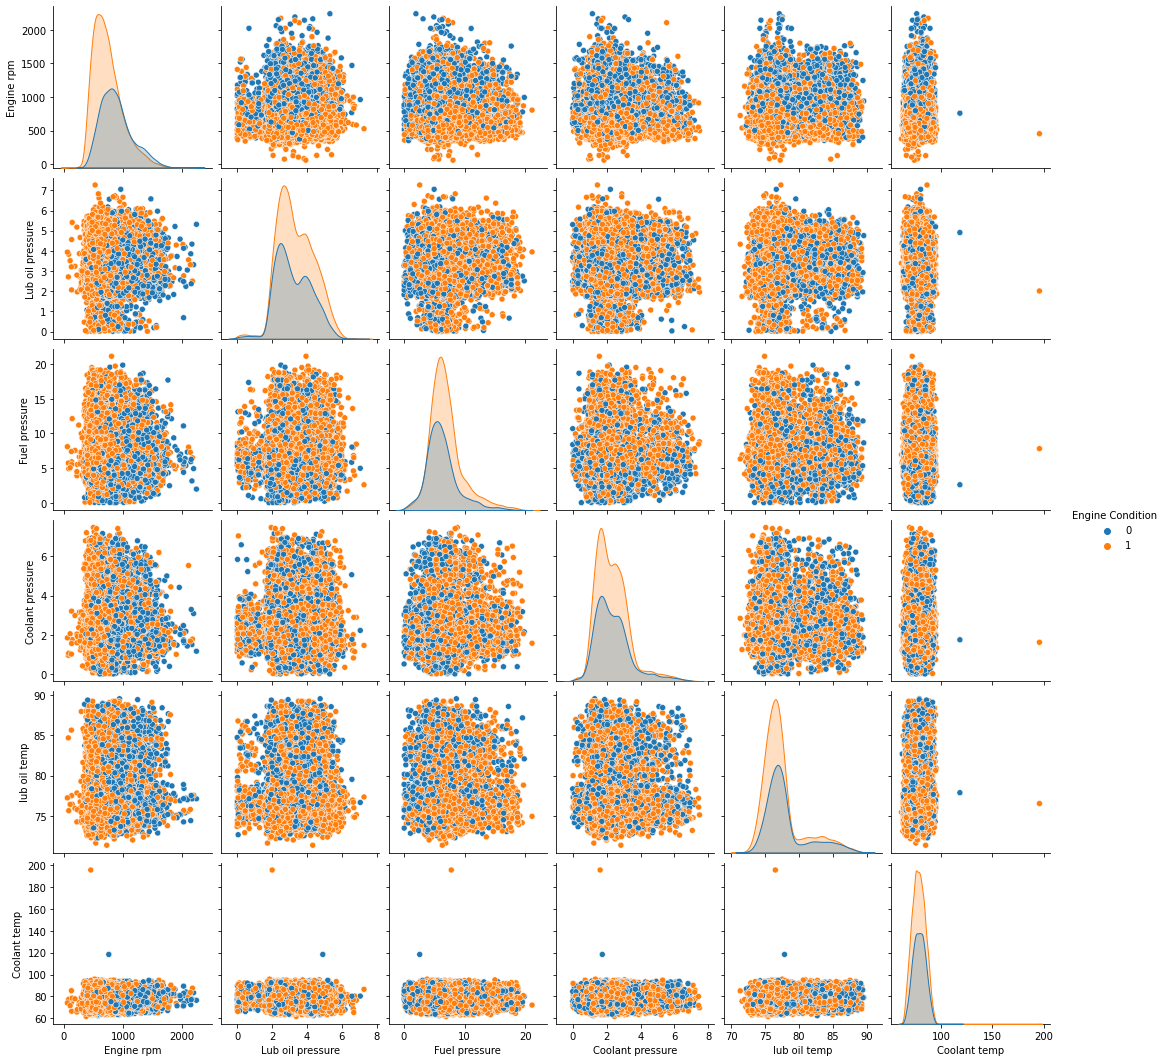

In [12]:
plt.figure(figsize = (15,20))
sns.pairplot(data = df, hue = 'Engine Condition')

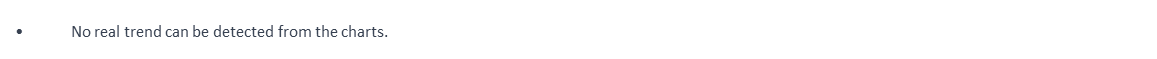

## Distributin of target

<AxesSubplot:xlabel='count', ylabel='Engine Condition'>

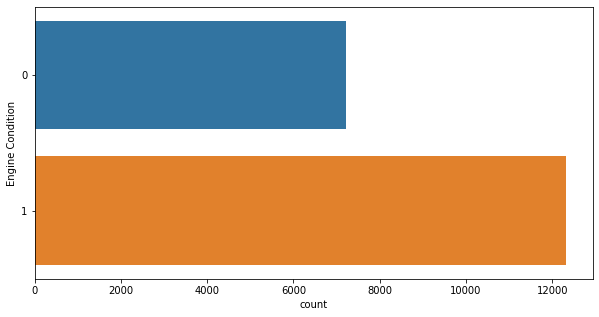

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(y = df['Engine Condition'])

In [14]:
# summarize the class distribution
counter = Counter(df['Engine Condition'])
for k,v in counter.items():
    per = v / len(df['Engine Condition']) * 100
    print('Class=%d -- Count=%d -- Percentage=%.2f%%' % (k, v, per))

Class=1 -- Count=12317 -- Percentage=63.05%
Class=0 -- Count=7218 -- Percentage=36.95%


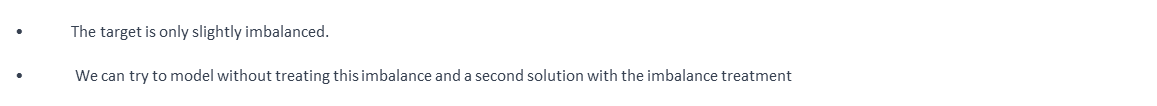

## Features Distriubution


In [15]:
def plot_and_test_normality(df):
    for column in df.columns:
        data = df[column]

        # Plotting the histogram
        plt.hist(data, bins='auto')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.title('Histogram of ' + column)
        plt.show()

        # Normality test (Shapiro-Wilk test)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            stat, p_value = shapiro(data)

        # Displaying the normality test result
        print("Variable:", column)
        print("Test statistic:", stat)
        print("p-value:", p_value)
        if p_value > 0.05:
            print("The variable follows a normal distribution.")
        else:
            print("The variable does not follow a normal distribution.")
        print("--------------------")

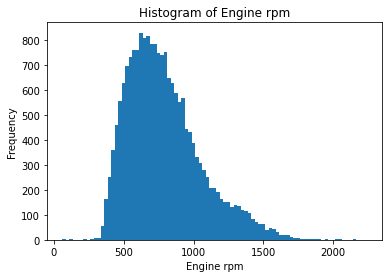

Variable: Engine rpm
Test statistic: 0.9469200372695923
p-value: 0.0
The variable does not follow a normal distribution.
--------------------


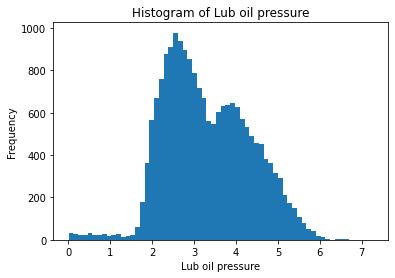

Variable: Lub oil pressure
Test statistic: 0.9816726446151733
p-value: 8.688050478813866e-44
The variable does not follow a normal distribution.
--------------------


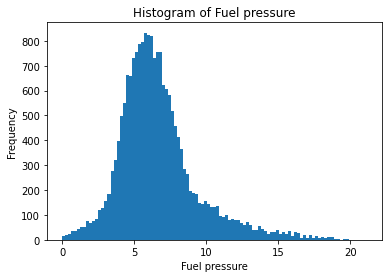

Variable: Fuel pressure
Test statistic: 0.9237937927246094
p-value: 0.0
The variable does not follow a normal distribution.
--------------------


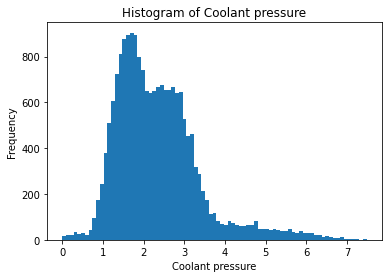

Variable: Coolant pressure
Test statistic: 0.9146561622619629
p-value: 0.0
The variable does not follow a normal distribution.
--------------------


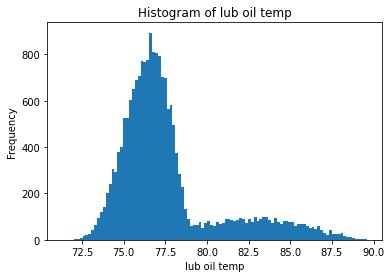

Variable: lub oil temp
Test statistic: 0.8388867378234863
p-value: 0.0
The variable does not follow a normal distribution.
--------------------


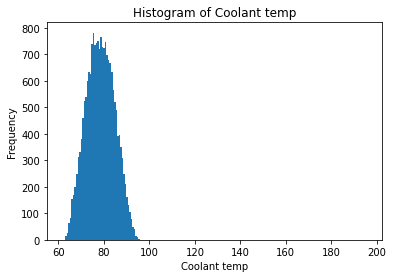

Variable: Coolant temp
Test statistic: 0.9824640154838562
p-value: 4.610271947628648e-43
The variable does not follow a normal distribution.
--------------------


In [16]:
plot_and_test_normality(df.iloc[:,:-1])

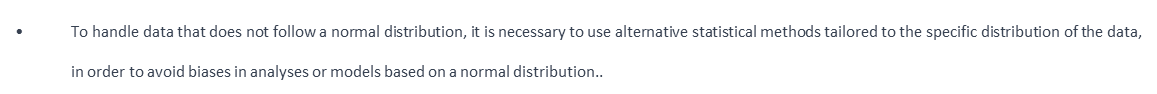

# Baseline Dummy Model

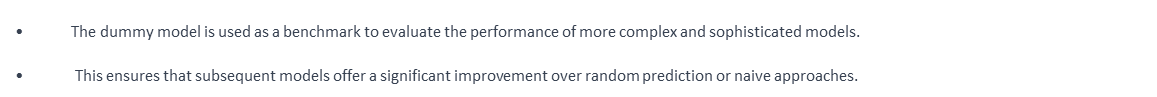

In [17]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [18]:
# Split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

In [19]:
# summarize the class distribution
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d -- Count=%d -- Percentage=%.2f%%' % (k, v, per))

Class=1 -- Count=9872 -- Percentage=63.17%
Class=0 -- Count=5756 -- Percentage=36.83%


In [20]:
clf_dummy = DummyClassifier(random_state=39)
clf_dummy.fit(X_train,y_train)
y_pred = clf_dummy.predict(X_test)

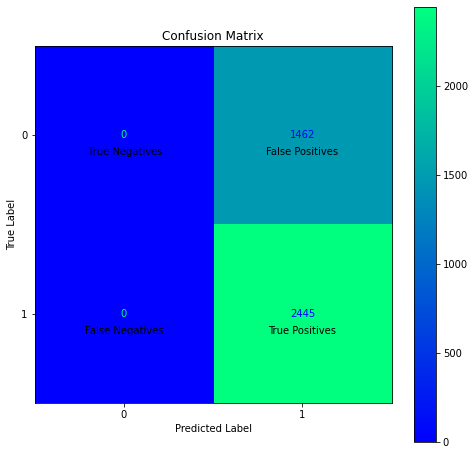

In [21]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object with the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# Display the confusion matrix with labels
fig, ax = plt.subplots(figsize=(8, 8))
cm_display.plot(ax=ax, cmap='winter')

# Add labels to the cells of the confusion matrix
ax.text(0, 0, '\n True Negatives', ha='center', va='top')
ax.text(0, 1, '\nFalse Negatives', ha='center', va='top')
ax.text(1, 0, '\nFalse Positives', ha='center', va='top')
ax.text(1, 1, '\nTrue Positives', ha='center', va='top')

# Add a title and axis labels
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label');


In [22]:
accuracy_dummy = accuracy_score(y_test, y_pred)
auc_dummy = roc_auc_score(y_test, clf_dummy.predict_proba(X_test)[:, 1])
f1_dummy = f1_score(y_test, y_pred)

In [23]:
data = [['dummy',accuracy_dummy,f1_dummy,auc_dummy]]
df_score = pd.DataFrame(data, columns=['Model', 'Accuracy','f1','AUC'])

# GridSearch CV

## Without imbalanced

In [24]:
# Step 1 : preprocessor
preprocessor = PowerTransformer(method='box-cox', standardize=True)

In [25]:
# Step 2 : Parameters to be tested

cv=KFold(n_splits=5, shuffle=True, random_state=42)

param_lr = {
    'model__penalty': ['l2'],
    'model__C': [2, 0.001],
    'model__solver': [ 'liblinear'],
    'model__max_iter': [250,1000]
}

param_knn = {'model__n_neighbors': [3, 100]}

param_lgb = {
    'model__boosting_type': ['gbdt'],
    'model__num_leaves': [31, 100],
    'model__learning_rate': [0.05, 0.1],
    'model__n_estimators': [50, 100]}

param_rdmfor = {'model__max_depth': [1000,1],
                'model__min_samples_leaf' : [50,100],
               'model__n_estimators':[9,100]}
            



In [26]:
# Step 3 : Models

models_ = { 'LogisticRegression':{'model':LogisticRegression(),'params':param_lr},
    'KNN':{'model': KNeighborsClassifier(), 'params': param_knn},
    'LGBMMODEL':{'model': lgb.LGBMClassifier(), 'params': param_lgb},
    'RandomForestClassifier':{'model': RandomForestClassifier(), 'params':param_rdmfor}
              }

In [51]:
def train_model(X_train, y_train, X_test, y_test, model_name, param_name, cv):
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_name)])
    gscv = GridSearchCV(pipe, param_grid=param_name, cv=cv, scoring='accuracy', refit=True)
    gscv.fit(X_train, y_train)
    gscv_best = gscv.best_estimator_
    run_name = f"{model_name}"
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(gscv.best_params_)
        mlflow.sklearn.log_model(gscv_best, f"{model_name}-model")
        y_pred_scores = gscv_best.predict_proba(X_test)[:, 1]
        y_pred = np.where(y_pred_scores >= 0.5, 1, 0)
        mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
        mlflow.log_metric("score_auc", roc_auc_score(y_test, y_pred_scores))
        mlflow.log_metric('score_f1',f1_score(y_test, y_pred))
        mlflow.log_metric('score_recall',recall_score(y_test, y_pred))
        
        scores_auc = []
        scores_acc = []
        scores_f1 = []
        scores_recall = []
        
        thresholds = [0.5,0.6,0.7,0.8,0.9]
        for t in thresholds:
            y_pred = np.where(y_pred_scores >= t, 1, 0)
            scores_auc.append(roc_auc_score(y_test, y_pred))
            scores_acc.append(accuracy_score(y_test, y_pred))
            scores_f1.append(f1_score(y_test, y_pred))
            scores_recall.append(recall_score(y_test, y_pred))
            cm = confusion_matrix(y_test, y_pred)

            # confusion matrix
            cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
            fig, ax = plt.subplots(figsize=(8, 8))
            cm_display.plot(ax=ax, cmap='summer_r')
            ax.text(0, 0, '\n True Negatives', ha='center', va='top')
            ax.text(0, 1, '\nFalse Negatives',ha='center', va='top')
            ax.text(1, 0, '\nFalse Positives',ha='center', va='top')
            ax.text(1, 1, '\nTrue Positives',ha='center', va='top')
            ax.set_title('Confusion Matrix : '+run_name+' '+'thresholds '+str(t))
            ax.set_xlabel('Predicted Label')
            ax.set_ylabel('True Label')


        df_scores = pd.DataFrame({'Threshold': thresholds,
                                      'AUC': scores_auc,
                                      'Accuracy': scores_acc,
                                      'f1_score': scores_f1,
                                      'Recall_score':scores_recall})
        print(run_name)
        print(df_scores)

        fig, ax1 = plt.subplots()
        ax1.set_xlabel('Threshold')
        ax1.set_ylabel('Scores', color='black')
        df_scores.plot(kind='bar',
                       x='Threshold',
                       y=['AUC', 'Accuracy','f1_score','Recall_score'],
                       ax=ax1, 
                       color=['red', 'blue','pink','orange'])
        ax1.set_ylim([0, 1])
        ax1.legend(loc='lower left')
        ax1.set_title(run_name)        

        return gscv_best


LogisticRegression()
   Threshold       AUC  Accuracy  f1_score  Recall_score
0        0.5  0.597355  0.665216  0.764239      0.867076
1        0.6  0.640320  0.655490  0.717938      0.700613
2        0.7  0.647076  0.602508  0.596728      0.469939
3        0.8  0.576610  0.481444  0.323765      0.198364
4        0.9  0.505930  0.381623  0.023444      0.011861
KNeighborsClassifier()
   Threshold       AUC  Accuracy  f1_score  Recall_score
0        0.5  0.578309  0.655490  0.762778      0.885072
1        0.6  0.637478  0.648835  0.708705      0.682618
2        0.7  0.642330  0.592782  0.577872      0.445399
3        0.8  0.569516  0.473253  0.307537      0.186912
4        0.9  0.510627  0.388533  0.049343      0.025358
LGBMClassifier()
   Threshold       AUC  Accuracy  f1_score  Recall_score
0        0.5  0.594837  0.661377  0.760543      0.859305
1        0.6  0.645845  0.651907  0.706644      0.669939
2        0.7  0.641481  0.596365  0.589002      0.462168
3        0.8  0.585527  0.4

<ipython-input-51-1d42145f3295>:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 8))


RandomForestClassifier()
   Threshold       AUC  Accuracy  f1_score  Recall_score
0        0.5  0.601536  0.667008  0.764098      0.861759
1        0.6  0.641483  0.646276  0.700347      0.660532
2        0.7  0.641481  0.596365  0.589002      0.462168
3        0.8  0.581303  0.488866  0.343740      0.213906
4        0.9  0.522883  0.405938  0.109021      0.058078


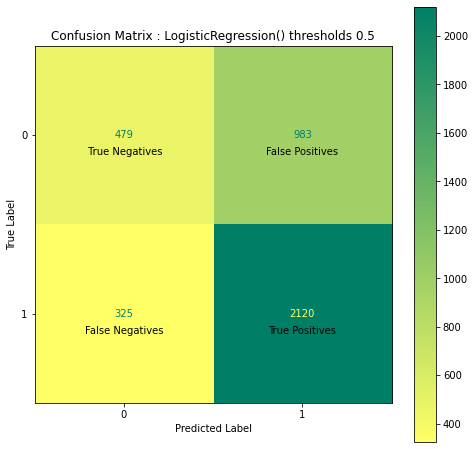

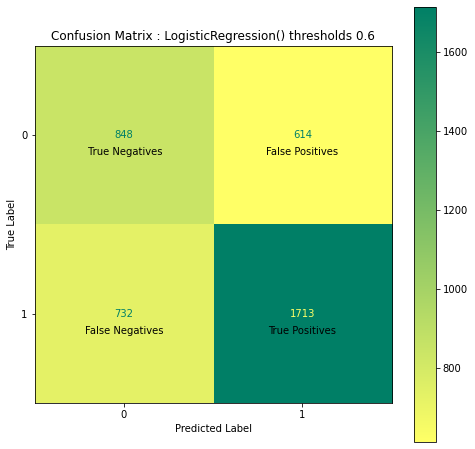

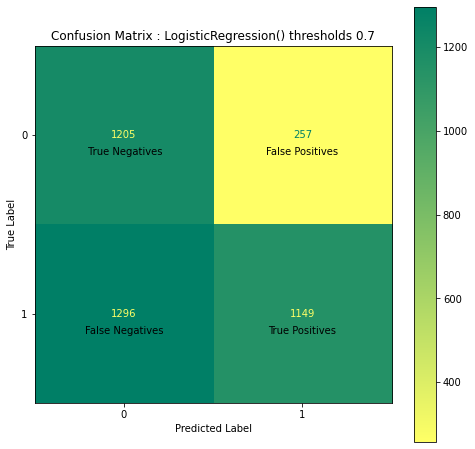

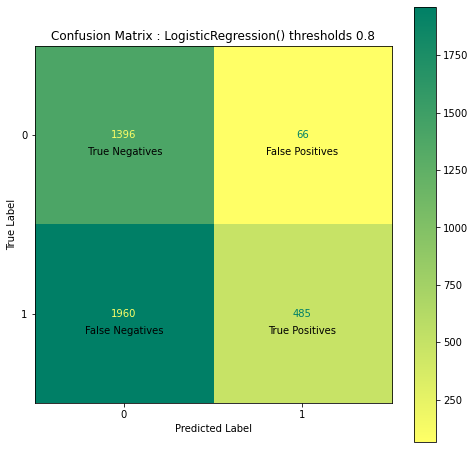

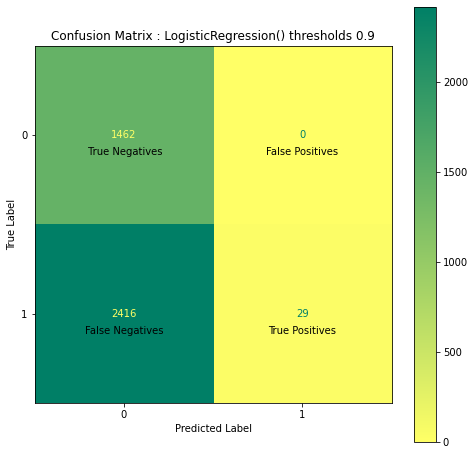

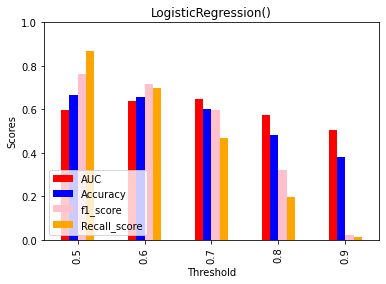

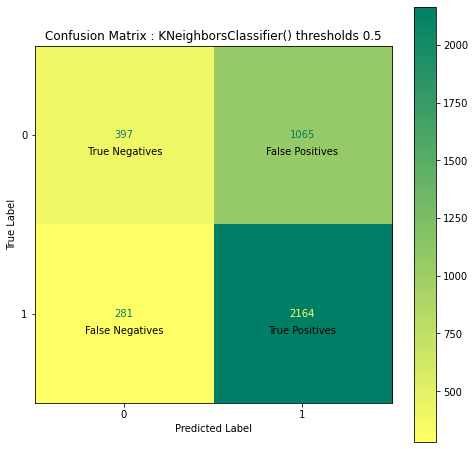

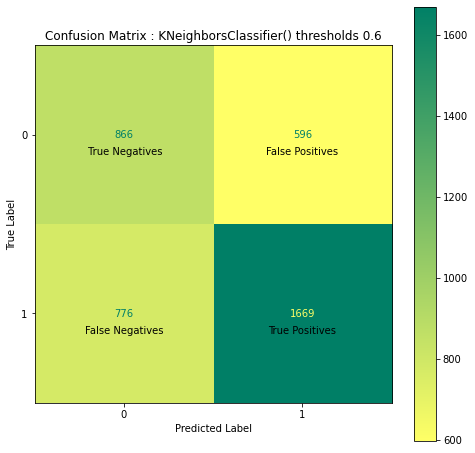

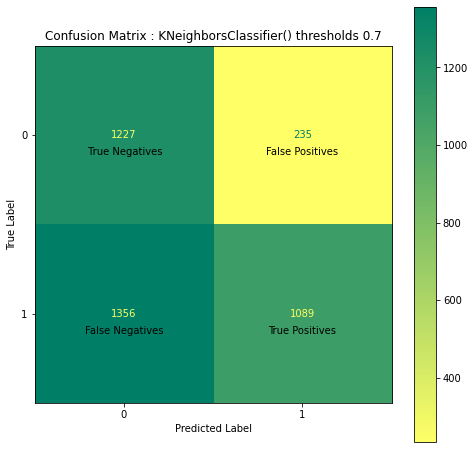

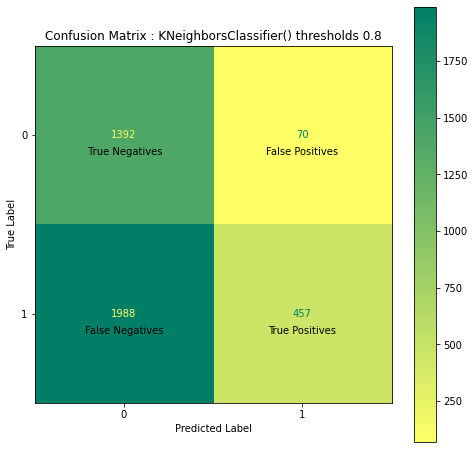

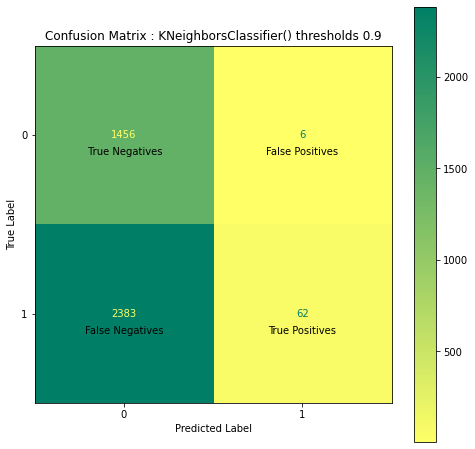

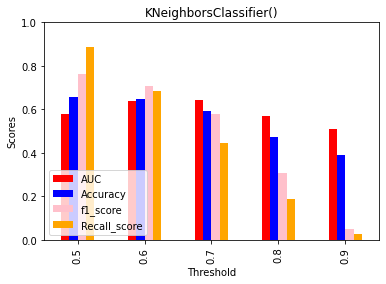

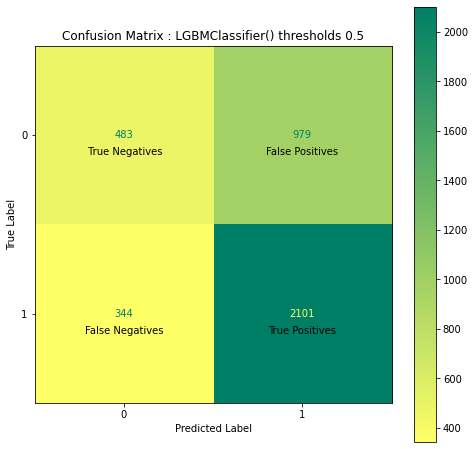

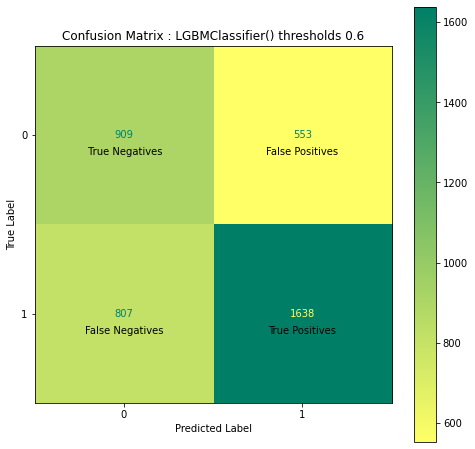

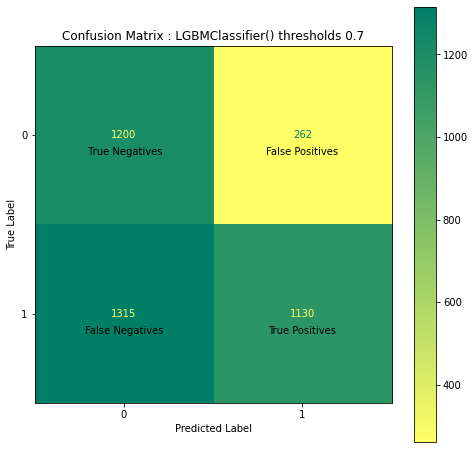

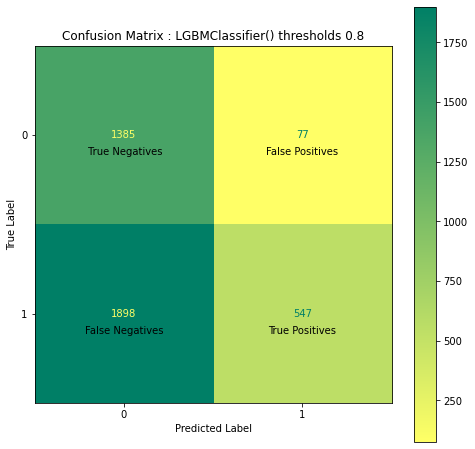

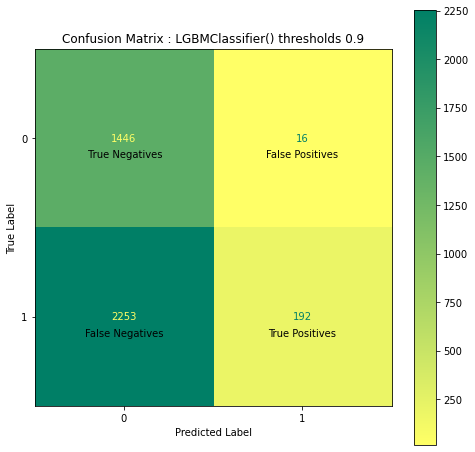

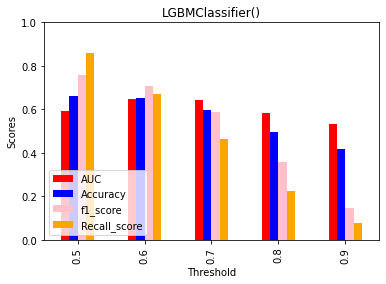

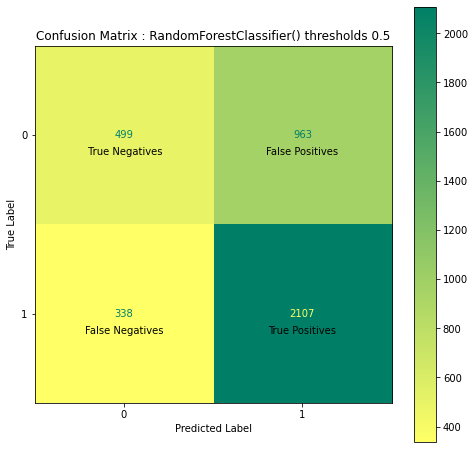

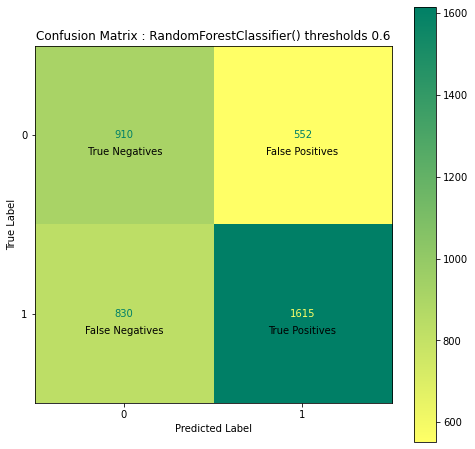

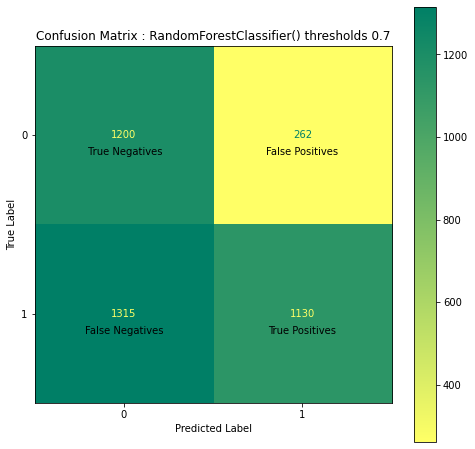

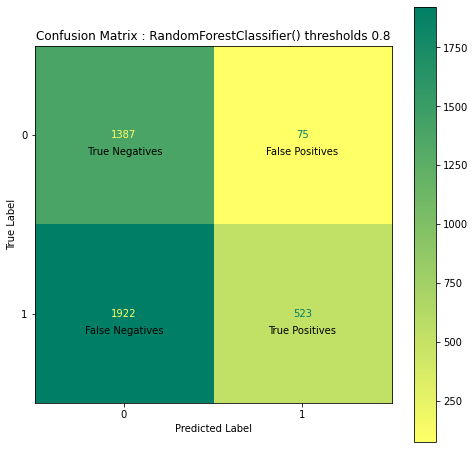

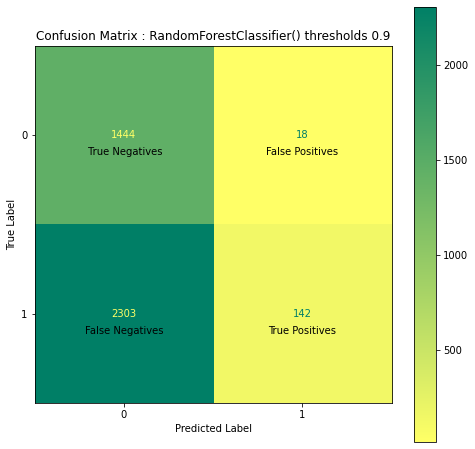

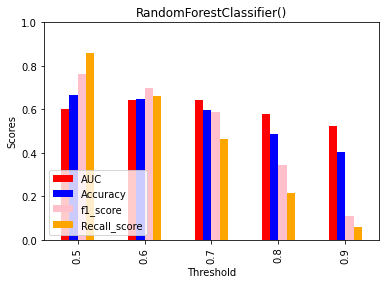

In [52]:
mlflow.set_experiment('with_imbalanced_outliers')
for model in models_.keys():
    train_model(X_train,y_train,X_test,y_test,models_[model]['model'],models_[model]['params'],cv)
mlflow.end_run()

## Dealing with imbalanced

In [53]:

under= RandomUnderSampler(sampling_strategy=0.8)

steps = [['u',under]]
sampling_pipeline = ImbPipeline(steps=steps)

# transform the dataset
X_train_resampled, y_train_resampled= sampling_pipeline.fit_resample(X_train, y_train)

In [54]:
# summarize the resampled class distribution
counter = Counter(y_train_resampled)
for k,v in counter.items():
    per = v / len(y_train_resampled) * 100
    print('Class=%d -- Count=%d -- Percentage=%.2f%%' % (k, v, per))

Class=0 -- Count=5756 -- Percentage=44.44%
Class=1 -- Count=7195 -- Percentage=55.56%


2023/05/22 10:28:38 INFO mlflow.tracking.fluent: Experiment with name 'fix_imbalanced_with_outliers' does not exist. Creating a new experiment.


LogisticRegression()
   Threshold       AUC  Accuracy  f1_score  Recall_score
0        0.5  0.630890  0.657282  0.728783      0.735787
1        0.6  0.646350  0.598157  0.586189      0.454806
2        0.7  0.563681  0.461991  0.270645      0.159509
3        0.8  0.505317  0.380855  0.021044      0.010634
4        0.9  0.500204  0.374456  0.000818      0.000409
KNeighborsClassifier()
   Threshold       AUC  Accuracy  f1_score  Recall_score
0        0.5  0.627325  0.655746  0.729104      0.740286
1        0.6  0.647415  0.613258  0.623474      0.511656
2        0.7  0.605463  0.524955  0.429274      0.285481
3        0.8  0.538009  0.425902  0.167718      0.092434
4        0.9  0.502454  0.377272  0.009768      0.004908
LGBMClassifier()
   Threshold       AUC  Accuracy  f1_score  Recall_score
0        0.5  0.637556  0.657538  0.723782      0.716973
1        0.6  0.649538  0.614538  0.623688      0.510429
2        0.7  0.609063  0.531354  0.444983      0.300204
3        0.8  0.548015  0.4

<ipython-input-51-1d42145f3295>:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 8))


RandomForestClassifier()
   Threshold       AUC  Accuracy  f1_score  Recall_score
0        0.5  0.635920  0.655490  0.721671      0.713701
1        0.6  0.652002  0.616074  0.624060      0.509202
2        0.7  0.613780  0.535193  0.448024      0.301431
3        0.8  0.535005  0.422831  0.162022      0.089162
4        0.9  0.500000  0.374200  0.000000      0.000000


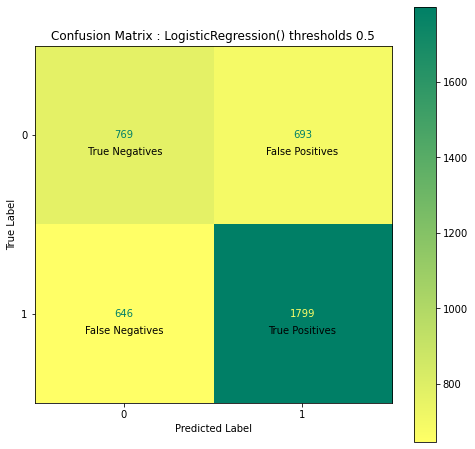

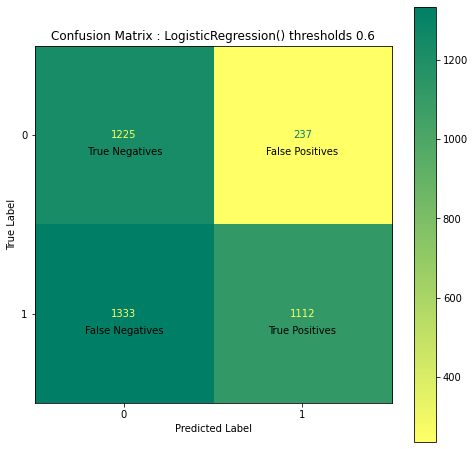

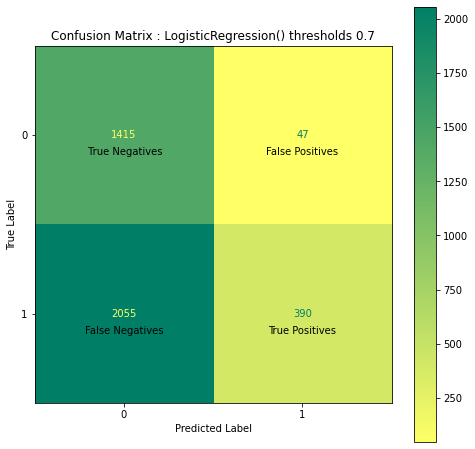

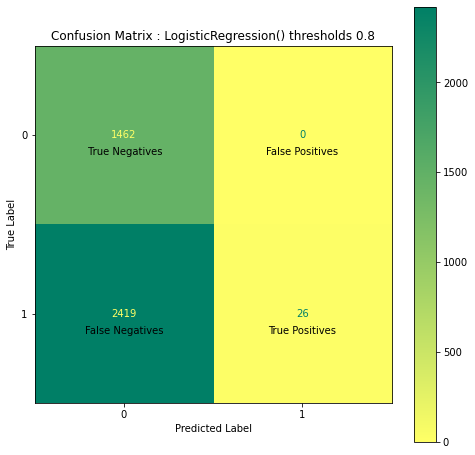

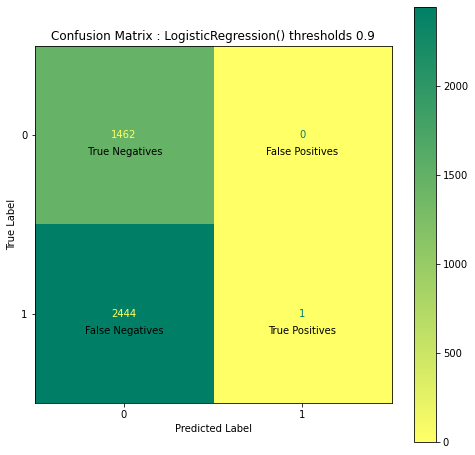

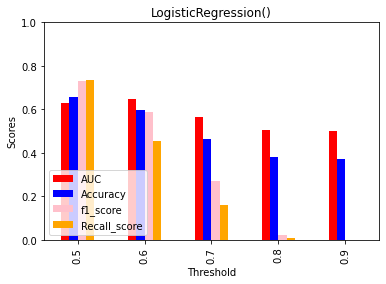

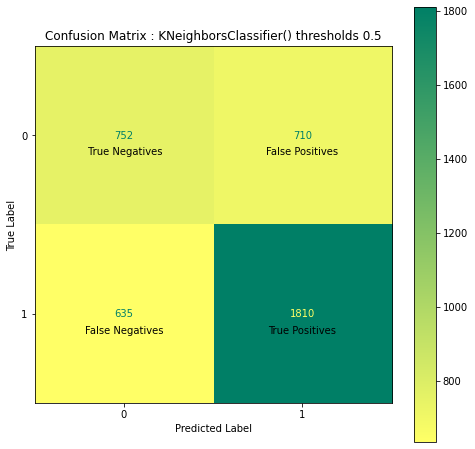

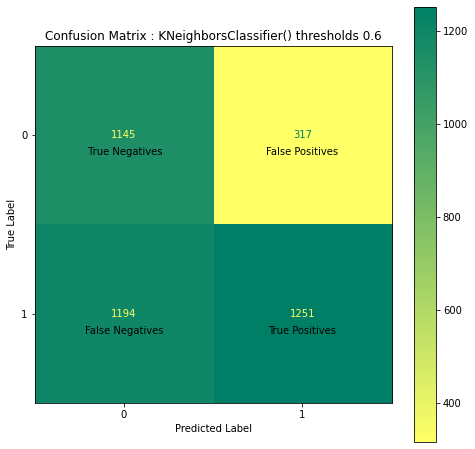

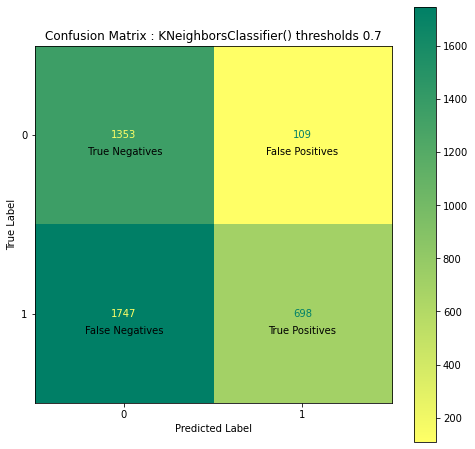

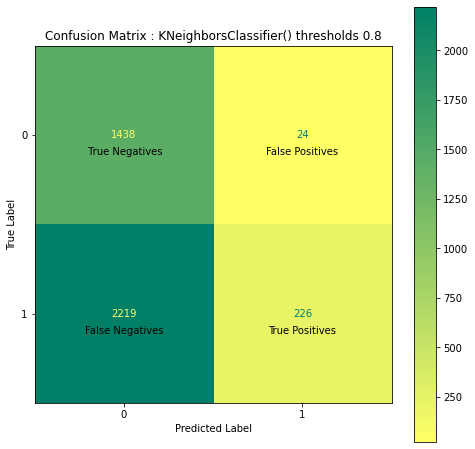

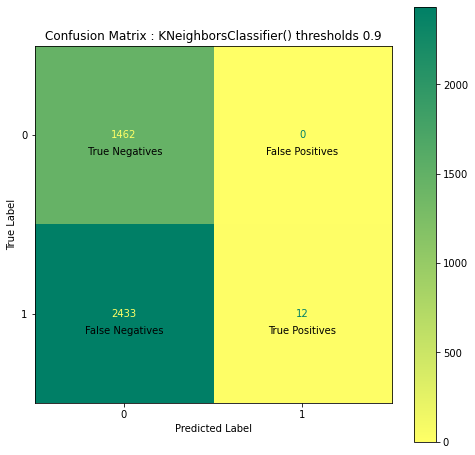

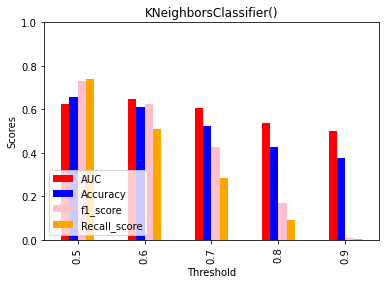

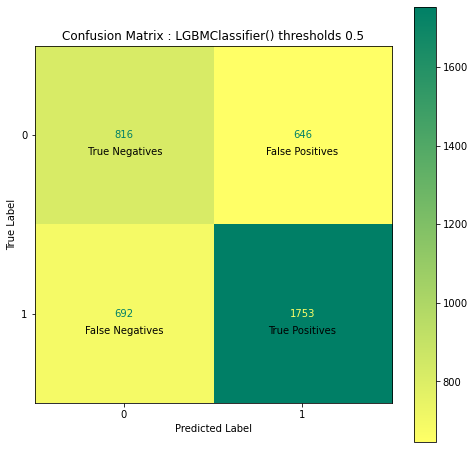

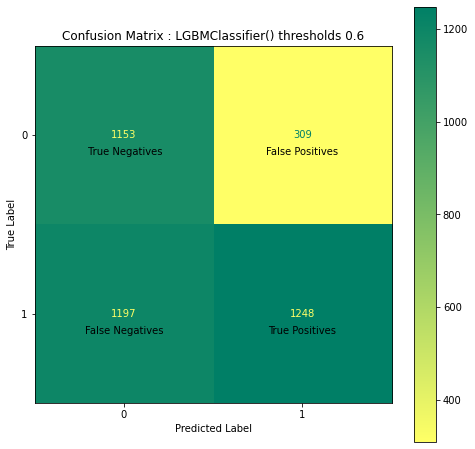

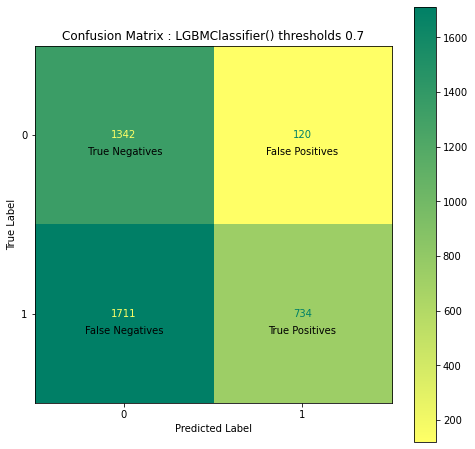

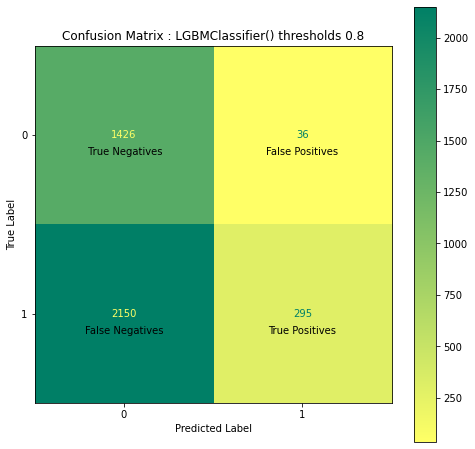

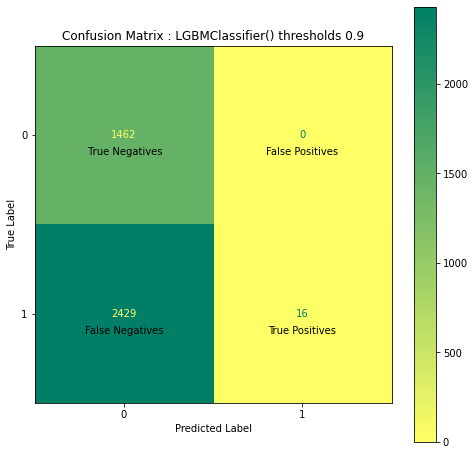

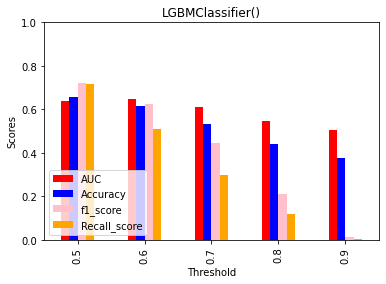

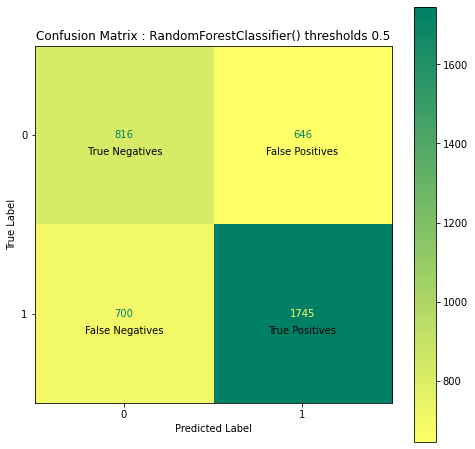

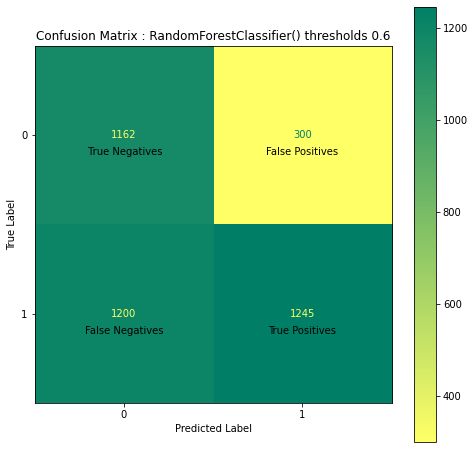

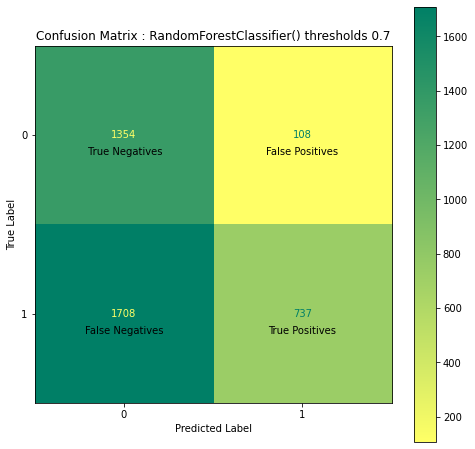

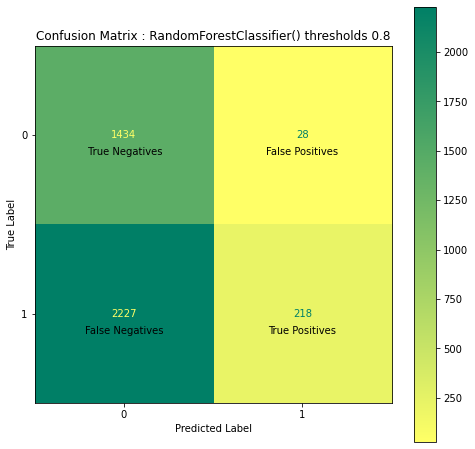

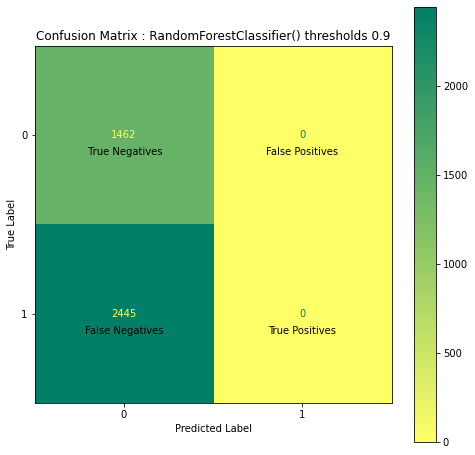

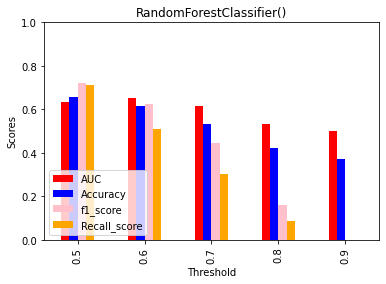

In [55]:
mlflow.set_experiment('fix_imbalanced_with_outliers')
for model in models_.keys():
    train_model(X_train_resampled,y_train_resampled,X_test,y_test,models_[model]['model'],models_[model]['params'],cv)
mlflow.end_run()

## Fix outliers

In [57]:
def drop_outliers(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    filtered_data = data[(z_scores < threshold).all(axis=1)]
    return filtered_data


In [58]:
filtered_df = drop_outliers(df.loc[X_train.index])


In [59]:
filtered_X_train = filtered_df.iloc[:,:-1]
filtered_y_train =filtered_df.iloc[:,-1]

In [60]:
filtered_X_train.shape, filtered_y_train.shape, X_test.shape,y_test.shape

((14660, 6), (14660,), (3907, 6), (3907,))

LogisticRegression()
   Threshold       AUC  Accuracy  f1_score  Recall_score
0        0.5  0.596177  0.666496  0.766697      0.875665
1        0.6  0.653146  0.649859  0.695865      0.640082
2        0.7  0.612056  0.535961  0.455065      0.309611
3        0.8  0.519142  0.400051  0.087227      0.045808
4        0.9  0.500613  0.374968  0.002451      0.001227
KNeighborsClassifier()
   Threshold       AUC  Accuracy  f1_score  Recall_score
0        0.5  0.571673  0.650627  0.760316      0.885481
1        0.6  0.635553  0.648835  0.710426      0.688344
2        0.7  0.645331  0.596365  0.582915      0.450716
3        0.8  0.569453  0.472485  0.303951      0.184049
4        0.9  0.508377  0.385718  0.040767      0.020859
LGBMClassifier()
   Threshold       AUC  Accuracy  f1_score  Recall_score
0        0.5  0.579546  0.655490  0.762023      0.881391
1        0.6  0.646331  0.651139  0.704787      0.665440
2        0.7  0.641569  0.593550  0.581224      0.450716
3        0.8  0.576543  0.4

<ipython-input-51-1d42145f3295>:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 8))


RandomForestClassifier()
   Threshold       AUC  Accuracy  f1_score  Recall_score
0        0.5  0.578376  0.655746  0.763079      0.885890
1        0.6  0.650009  0.656258  0.710747      0.674847
2        0.7  0.645387  0.598157  0.587710      0.457669
3        0.8  0.573141  0.476069  0.309146      0.187321
4        0.9  0.508585  0.385462  0.037675      0.019223


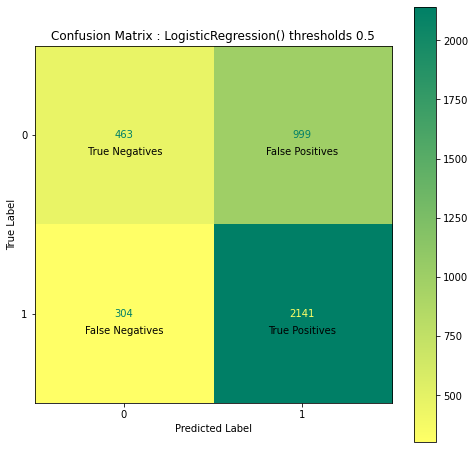

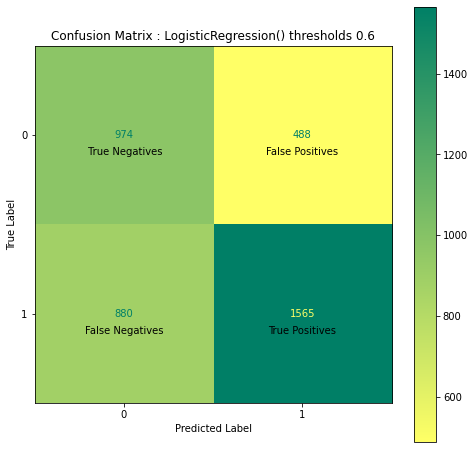

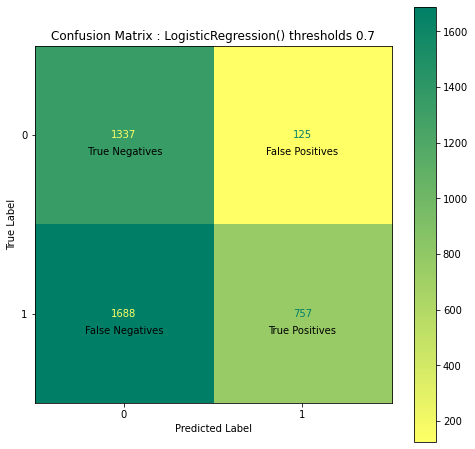

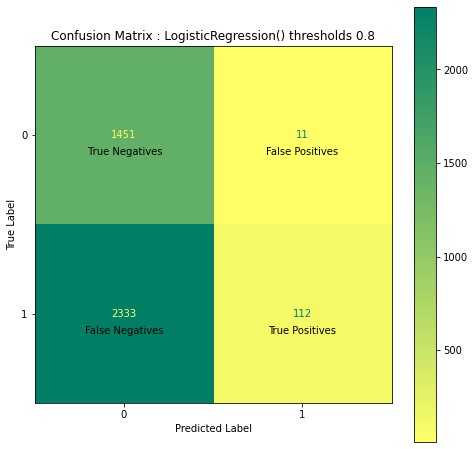

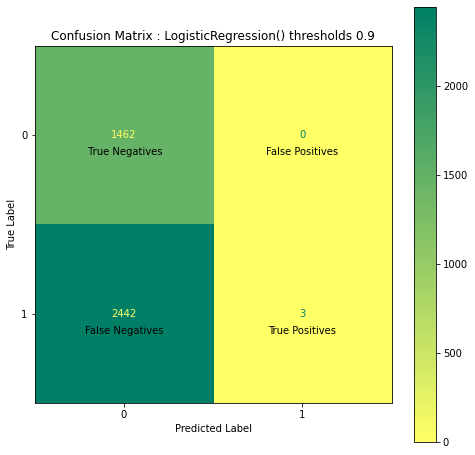

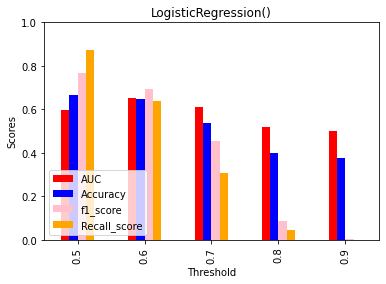

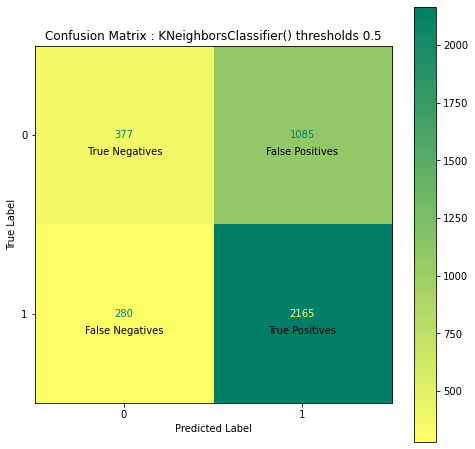

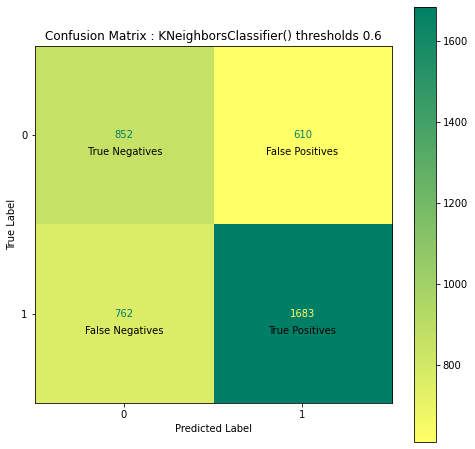

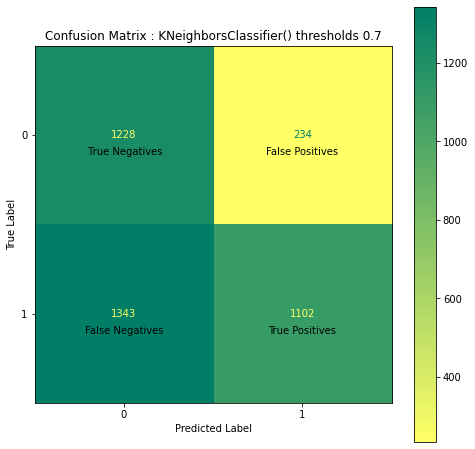

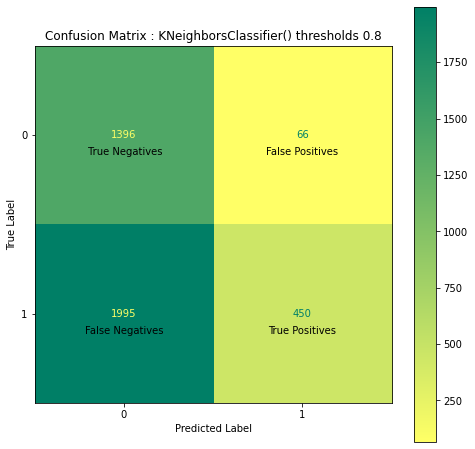

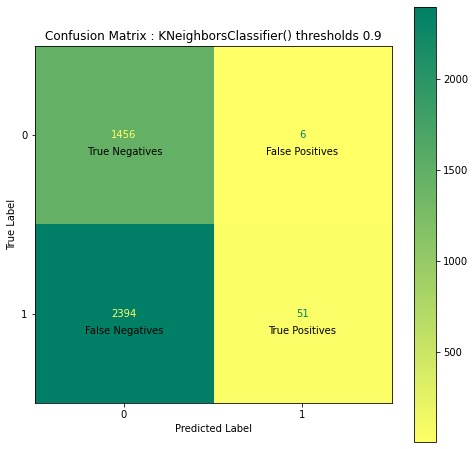

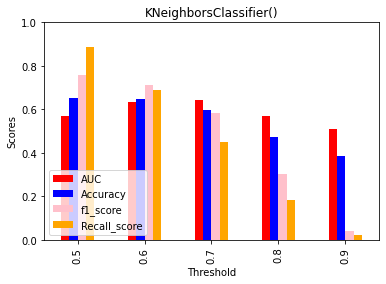

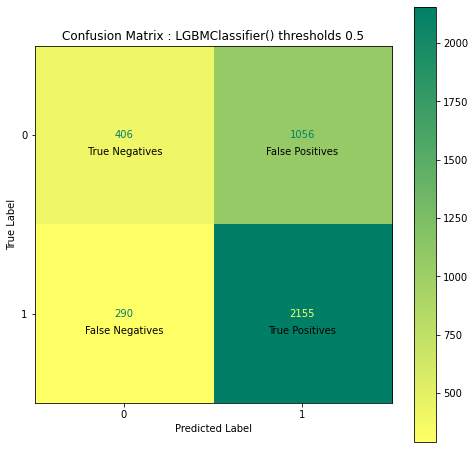

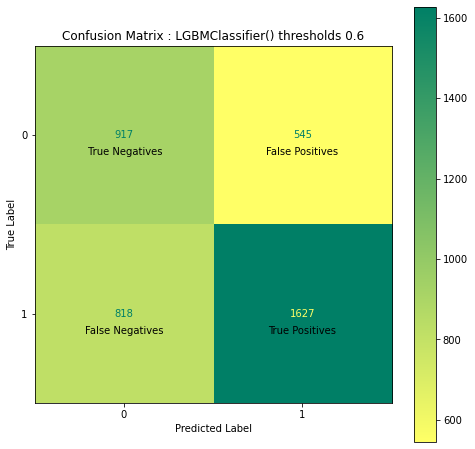

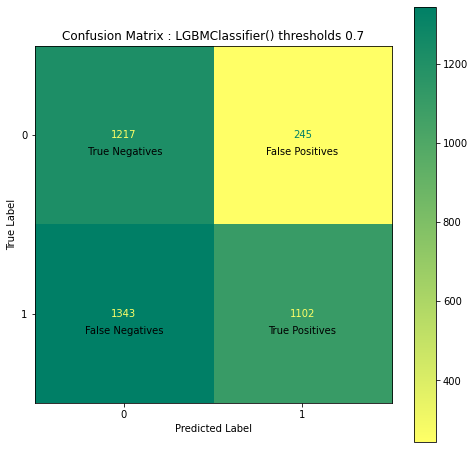

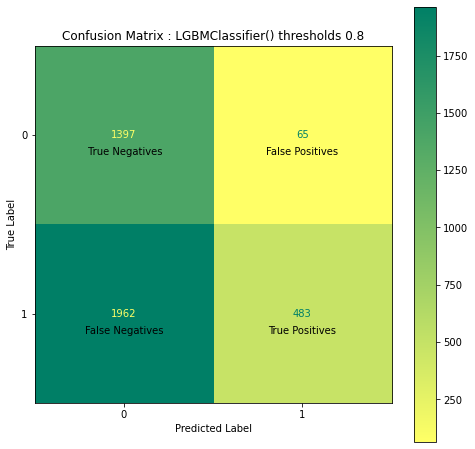

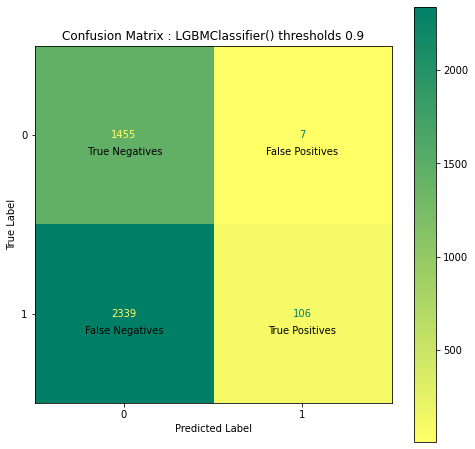

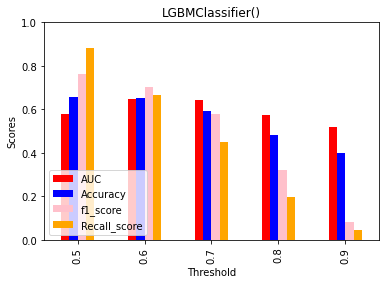

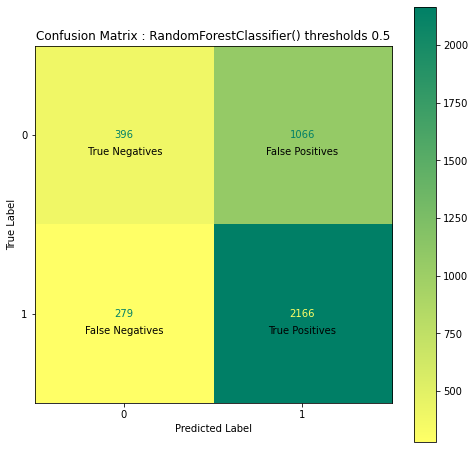

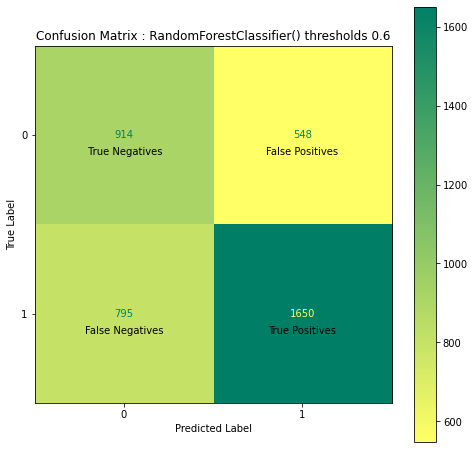

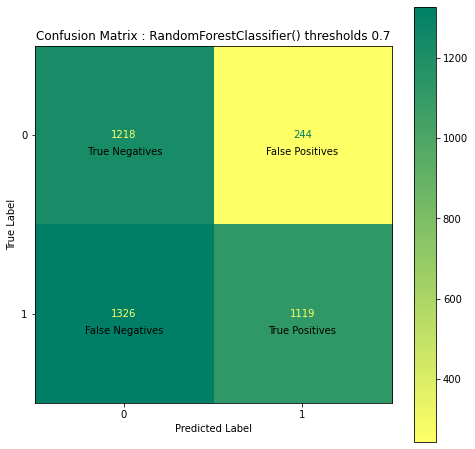

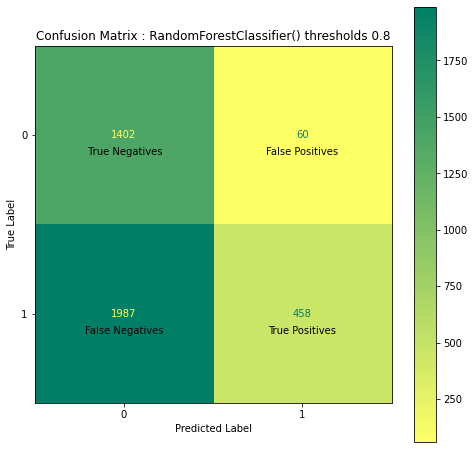

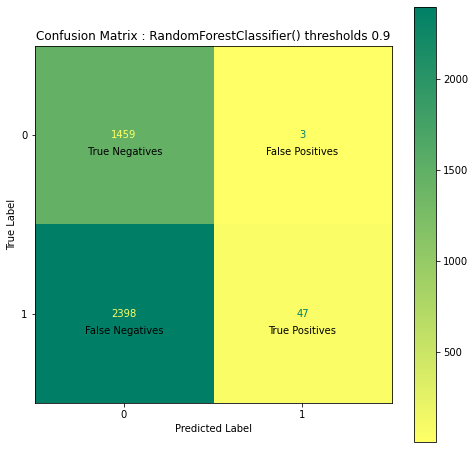

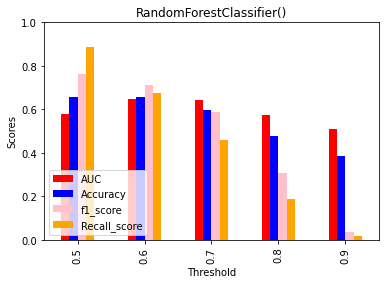

In [61]:
mlflow.set_experiment('fix_outliers_not_imbalanced')
for model in models_.keys():
    train_model(filtered_X_train,filtered_y_train,X_test,y_test,models_[model]['model'],models_[model]['params'],cv)
mlflow.end_run()

## Fix imbalanced and outliers

In [62]:
under= RandomUnderSampler(sampling_strategy=0.8)

steps = [['u',under]]
sampling_pipeline = ImbPipeline(steps=steps)

# transform the dataset
filtered_X_train_resampled, filtered_y_train_resampled= sampling_pipeline.fit_resample(filtered_X_train, filtered_y_train)

2023/05/22 10:36:26 INFO mlflow.tracking.fluent: Experiment with name 'fix_outliers_imbalanced' does not exist. Creating a new experiment.


LogisticRegression()
   Threshold       AUC  Accuracy  f1_score  Recall_score
0        0.5  0.629786  0.657794  0.730498      0.741104
1        0.6  0.656054  0.626824  0.644217      0.539877
2        0.7  0.612613  0.534937  0.449894      0.303885
3        0.8  0.538012  0.425390  0.164496      0.090389
4        0.9  0.501840  0.376504  0.007335      0.003681
KNeighborsClassifier()
   Threshold       AUC  Accuracy  f1_score  Recall_score
0        0.5  0.636616  0.664448  0.735952      0.747239
1        0.6  0.649739  0.615306  0.625280      0.512883
2        0.7  0.600918  0.515997  0.405159      0.263395
3        0.8  0.529906  0.414384  0.131359      0.070757
4        0.9  0.501703  0.376504  0.008143      0.004090
LGBMClassifier()
   Threshold       AUC  Accuracy  f1_score  Recall_score
0        0.5  0.640490  0.660865  0.726973      0.721472
1        0.6  0.646350  0.608139  0.612307      0.494479
2        0.7  0.604722  0.522652  0.422064      0.278528
3        0.8  0.550265  0.4

<ipython-input-51-1d42145f3295>:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 8))


RandomForestClassifier()
   Threshold       AUC  Accuracy  f1_score  Recall_score
0        0.5  0.641110  0.660609  0.726033      0.718609
1        0.6  0.652288  0.614538  0.619889      0.502249
2        0.7  0.613456  0.532378  0.438019      0.291207
3        0.8  0.532082  0.417968  0.144470      0.078528
4        0.9  0.500000  0.374200  0.000000      0.000000


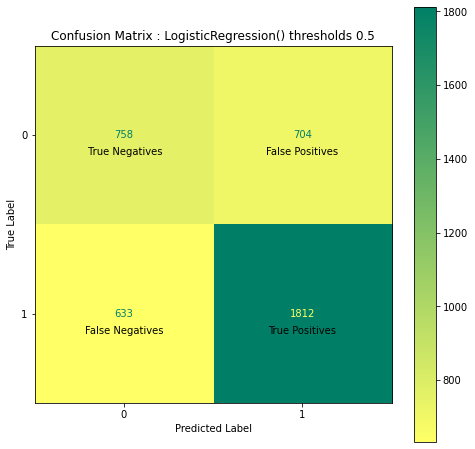

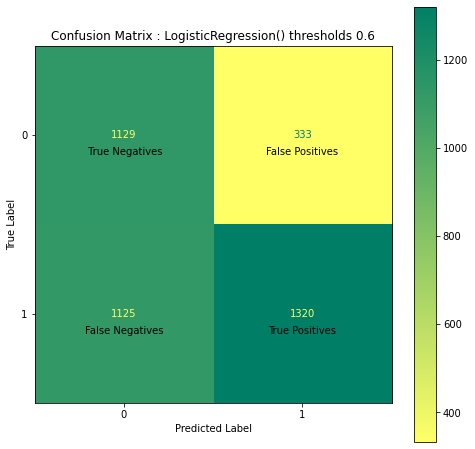

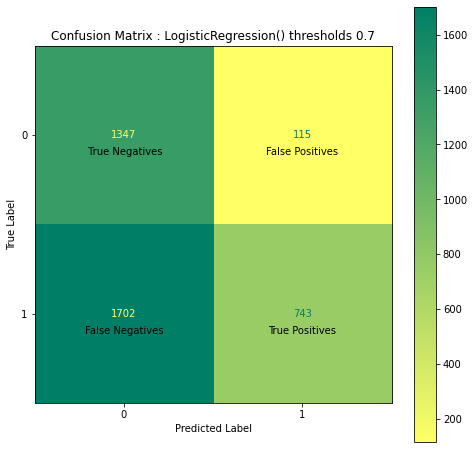

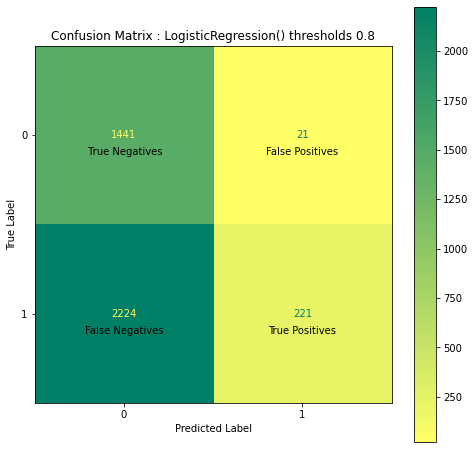

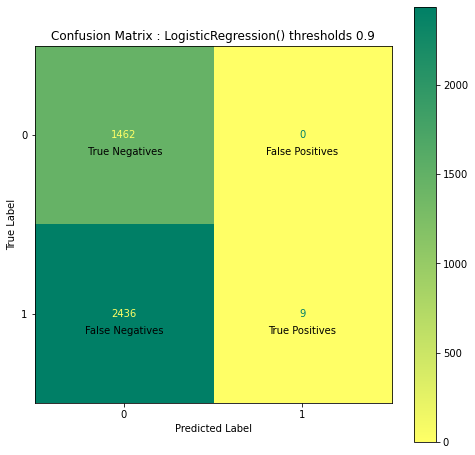

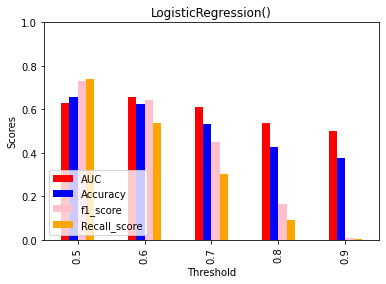

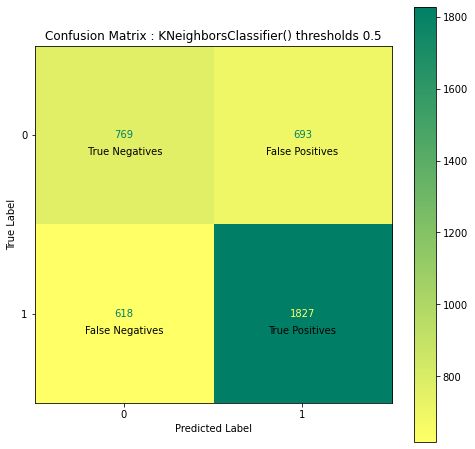

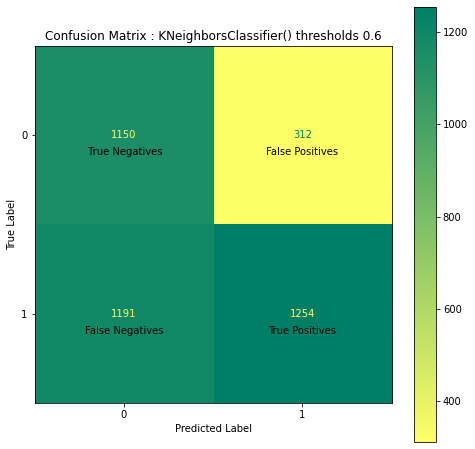

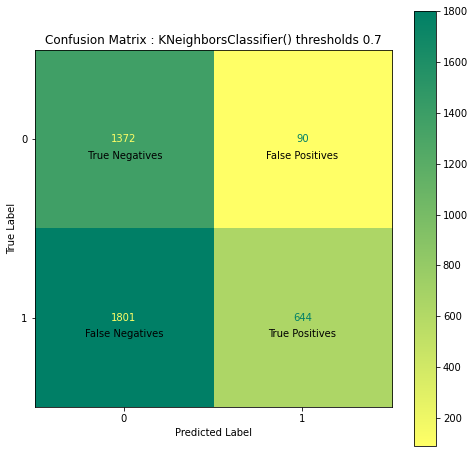

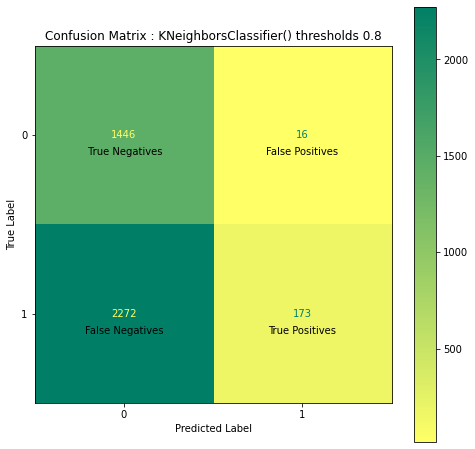

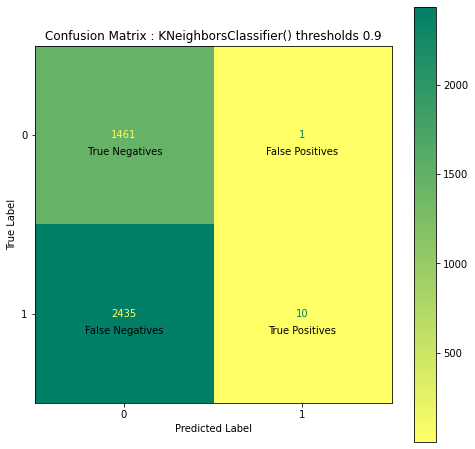

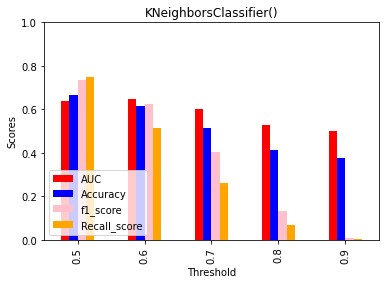

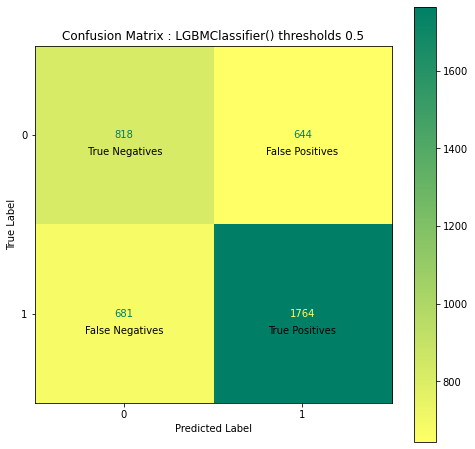

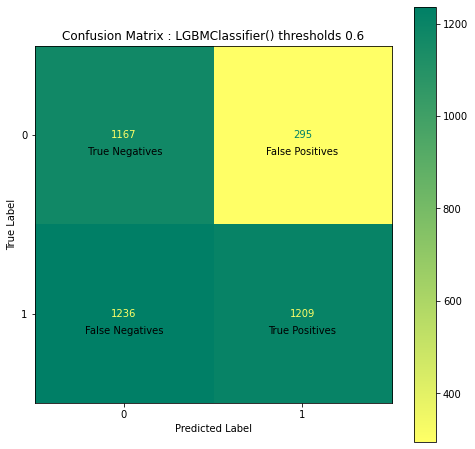

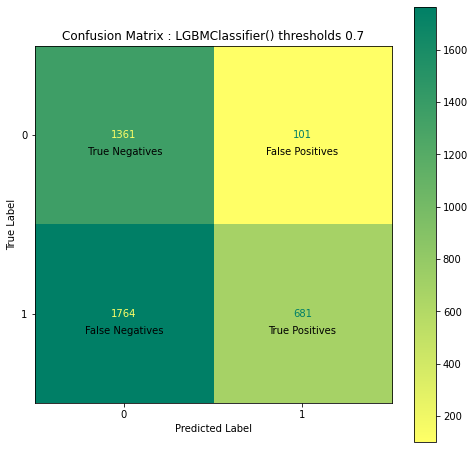

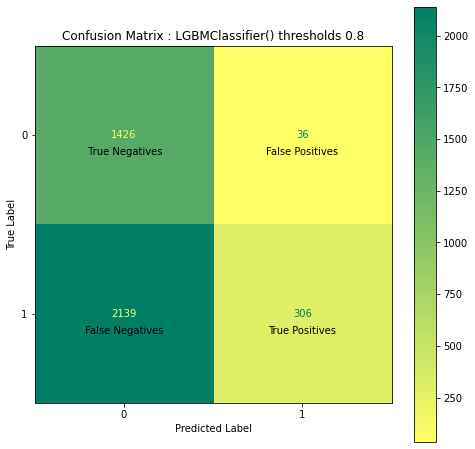

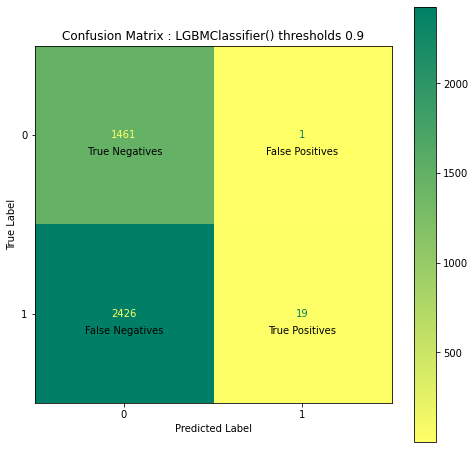

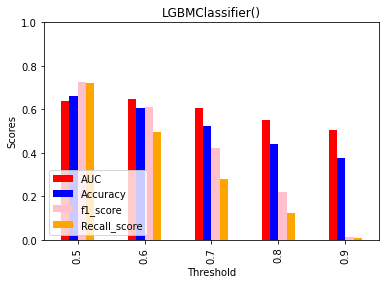

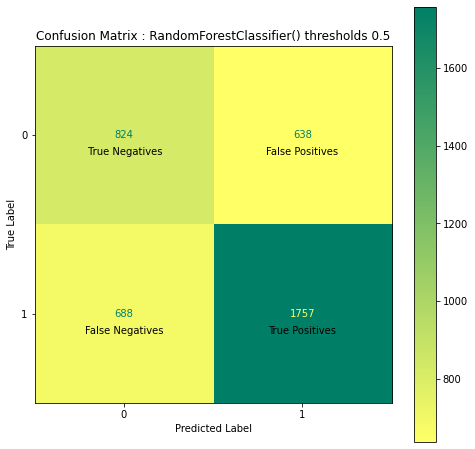

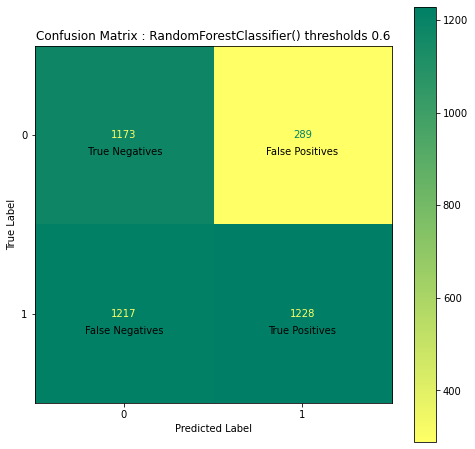

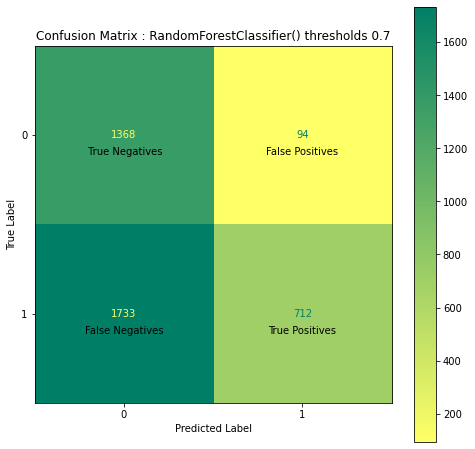

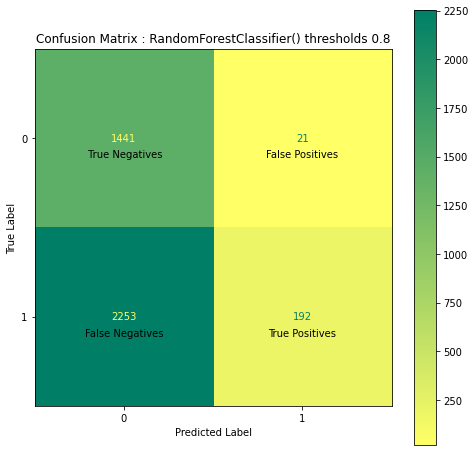

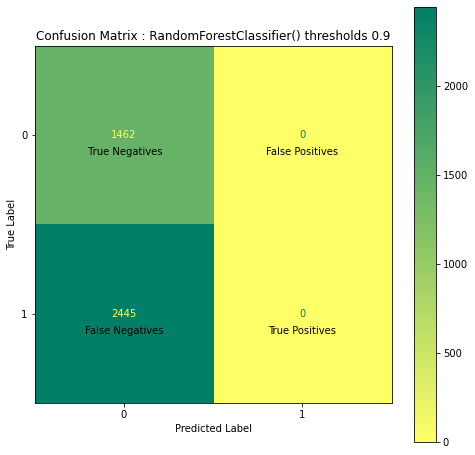

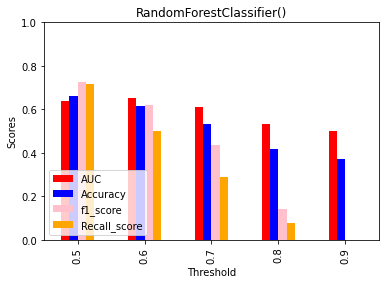

In [63]:
mlflow.set_experiment('fix_outliers_imbalanced')
for model in models_.keys():
    train_model(filtered_X_train_resampled,filtered_y_train_resampled,X_test,y_test,models_[model]['model'],models_[model]['params'],cv)
mlflow.end_run()

# Model choice

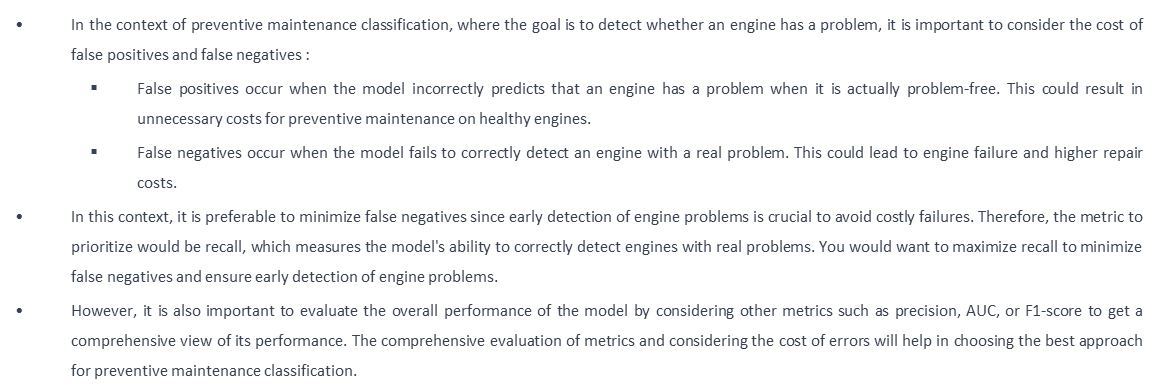

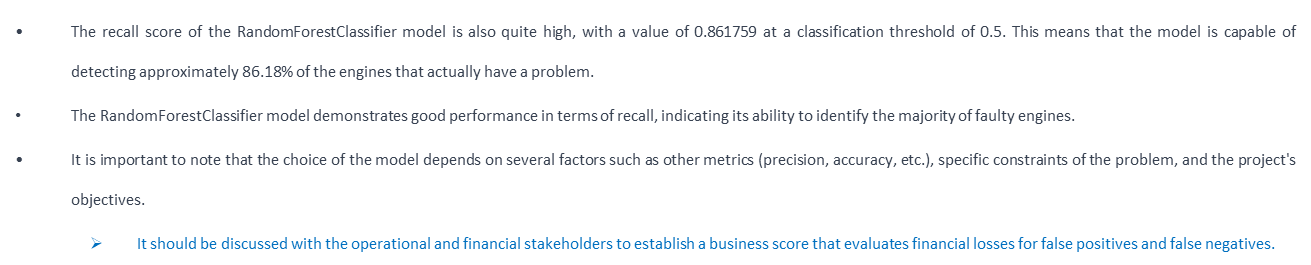

In [64]:
df_experiment = mlflow.search_runs(experiment_ids='184785230158866407', 
                              order_by=["metrics.score_auc DESC"], 
                              max_results=10).sort_values(by=['start_time'])
df_experiment



,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.score_auc,metrics.score_f1,metrics.accuracy,metrics.score_recall,...,params.model__boosting_type,params.model__num_leaves,params.model__learning_rate,params.model__n_neighbors,tags.mlflow.source.git.commit,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.runName
2,f94d35665bd0438486c9f8272d204ea9,184785230158866407,FINISHED,file:///C:/Users/td/predictive_maintenance/not...,2023-05-22 08:18:55.057000+00:00,2023-05-22 08:19:05.920000+00:00,0.704557,0.764239,0.665216,0.867076,...,None,None,None,None,fc01337d1b8685b39f826405ad08feab8018b001,"[{""run_id"": ""f94d35665bd0438486c9f8272d204ea9""...",td,c:\users\td\appdata\local\programs\python\pyth...,LOCAL,LogisticRegression()
7,6c9c80e5cc98482e88e2d127d74d4263,184785230158866407,FINISHED,file:///C:/Users/td/predictive_maintenance/not...,2023-05-22 08:19:15.839000+00:00,2023-05-22 08:19:26.855000+00:00,0.697203,0.762778,0.655490,0.885072,...,None,None,None,100,fc01337d1b8685b39f826405ad08feab8018b001,"[{""run_id"": ""6c9c80e5cc98482e88e2d127d74d4263""...",td,c:\users\td\appdata\local\programs\python\pyth...,LOCAL,KNeighborsClassifier()
5,e68d1a90b0a445f387639425eb90f7ef,184785230158866407,FINISHED,file:///C:/Users/td/predictive_maintenance/not...,2023-05-22 08:19:58.392000+00:00,2023-05-22 08:20:06.903000+00:00,0.702517,0.760543,0.661377,0.859305,...,gbdt,31,0.1,None,fc01337d1b8685b39f826405ad08feab8018b001,"[{""run_id"": ""e68d1a90b0a445f387639425eb90f7ef""...",td,c:\users\td\appdata\local\programs\python\pyth...,LOCAL,LGBMClassifier()
0,054cb813a051459f815ad272199bc859,184785230158866407,FINISHED,file:///C:/Users/td/predictive_maintenance/not...,2023-05-22 08:21:32.647000+00:00,2023-05-22 08:21:41.806000+00:00,0.704644,0.760253,0.660353,0.860532,...,None,None,None,None,fc01337d1b8685b39f826405ad08feab8018b001,"[{""run_id"": ""054cb813a051459f815ad272199bc859""...",td,c:\users\td\appdata\local\programs\python\pyth...,LOCAL,RandomForestClassifier()
1,92050b923ddf4cfe809d2a5bd7bb542e,184785230158866407,FINISHED,file:///C:/Users/td/predictive_maintenance/not...,2023-05-22 08:25:56.300000+00:00,2023-05-22 08:26:04.008000+00:00,0.704557,0.764239,0.665216,0.867076,...,None,None,None,None,fc01337d1b8685b39f826405ad08feab8018b001,"[{""run_id"": ""92050b923ddf4cfe809d2a5bd7bb542e""...",td,c:\users\td\appdata\local\programs\python\pyth...,LOCAL,LogisticRegression()
6,11fa65bc05ea4daea7bdfab069c76184,184785230158866407,FINISHED,file:///C:/Users/td/predictive_maintenance/not...,2023-05-22 08:26:13.455000+00:00,2023-05-22 08:26:21.830000+00:00,0.697203,0.762778,0.655490,0.885072,...,None,None,None,100,fc01337d1b8685b39f826405ad08feab8018b001,"[{""run_id"": ""11fa65bc05ea4daea7bdfab069c76184""...",td,c:\users\td\appdata\local\programs\python\pyth...,LOCAL,KNeighborsClassifier()
4,d5efdd3cffad4d1ea3c14924ab0bfbd1,184785230158866407,FINISHED,file:///C:/Users/td/predictive_maintenance/not...,2023-05-22 08:26:51.880000+00:00,2023-05-22 08:27:00.375000+00:00,0.702517,0.760543,0.661377,0.859305,...,gbdt,31,0.1,None,fc01337d1b8685b39f826405ad08feab8018b001,"[{""run_id"": ""d5efdd3cffad4d1ea3c14924ab0bfbd1""...",td,c:\users\td\appdata\local\programs\python\pyth...,LOCAL,LGBMClassifier()
3,8882e3d1ccf6441ea3bf047220d9ce1f,184785230158866407,FINISHED,file:///C:/Users/td/predictive_maintenance/not...,2023-05-22 08:28:22.385000+00:00,2023-05-22 08:28:29.732000+00:00,0.702614,0.764098,0.667008,0.861759,...,None,None,None,None,fc01337d1b8685b39f826405ad08feab8018b001,"[{""run_id"": ""8882e3d1ccf6441ea3bf047220d9ce1f""...",td,c:\users\td\appdata\local\programs\python\pyth...,LOCAL,RandomForestClassifier()


In [66]:
df_experiment.iloc[3]

run_id                                             054cb813a051459f815ad272199bc859
experiment_id                                                    184785230158866407
status                                                                     FINISHED
artifact_uri                      file:///C:/Users/td/predictive_maintenance/not...
start_time                                         2023-05-22 08:21:32.647000+00:00
end_time                                           2023-05-22 08:21:41.806000+00:00
metrics.score_auc                                                          0.704644
metrics.score_f1                                                           0.760253
metrics.accuracy                                                           0.660353
metrics.score_recall                                                       0.860532
params.model__max_depth                                                        1000
params.model__n_estimators                                                  

In [69]:
# Model selected
json_str = df_experiment['tags.mlflow.log-model.history'].iloc[3]
model_history = json.loads(json_str)
run_id = model_history[0]['run_id']
artifact_path = model_history[0]['artifact_path']

In [70]:
loaded_model = mlflow.sklearn.load_model('runs:/'+run_id+'/'+artifact_path)

# Zoom model

In [71]:
loaded_model

Pipeline(steps=[('preprocessor', PowerTransformer(method='box-cox')),
                ('model',
                 RandomForestClassifier(max_depth=1000, min_samples_leaf=50))])

In [73]:
loaded_model.fit(X,y)

Pipeline(steps=[('preprocessor', PowerTransformer(method='box-cox')),
                ('model',
                 RandomForestClassifier(max_depth=1000, min_samples_leaf=50))])

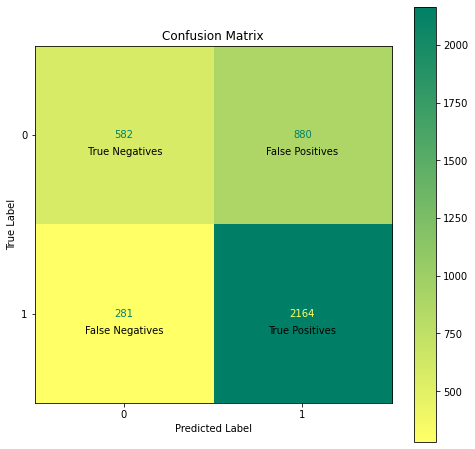

In [75]:
# Score
y_probabilities = loaded_model.predict_proba(X_test)
y_pred= np.where(y_probabilities[:, 1] >= 0.5, 1, 0)




# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Créer un objet ConfusionMatrixDisplay avec la matrice de confusion
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# Afficher la matrice de confusion avec des étiquettes
fig, ax = plt.subplots(figsize=(8, 8))
cm_display.plot(ax=ax, cmap='summer_r')

# Ajouter des étiquettes aux cellules de la matrice de confusion
ax.text(0, 0, '\n True Negatives', ha='center', va='top')
ax.text(0, 1, '\nFalse Negatives',ha='center', va='top')
ax.text(1, 0, '\nFalse Positives',ha='center', va='top')
ax.text(1, 1, '\nTrue Positives',ha='center', va='top')

# Ajouter un titre et des étiquettes d'axe
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label');



In [79]:
importances = loaded_model.named_steps['model'].feature_importances_

# Créer un DataFrame pour afficher les caractéristiques et leurs importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Afficher les caractéristiques importantes
print(feature_importances)

            Feature  Importance
0        Engine rpm    0.539484
2     Fuel pressure    0.185743
1  Lub oil pressure    0.108602
5      Coolant temp    0.085228
3  Coolant pressure    0.080943
4      lub oil temp    0.000000


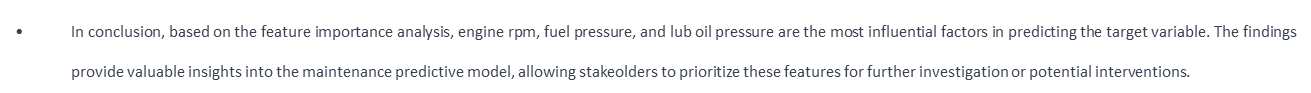